In [193]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [194]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [195]:
DATASET_PATH = './train.csv'
PREPARED_DATASET_PATH = './train_prepared.csv'
PREPARED_DATASET_PATH_TRAIN = './data/housing_prepared_train.csv'
PREPARED_DATASET_PATH_TEST = './data/housing_prepared_test.csv'

SCALER_FILE_PATH = './models/scaler.pkl'
MODEL_FILE_PATH = './models/model.pkl'

In [196]:
df = pd.read_csv(DATASET_PATH, sep=',')

# Уменьшение объема памяти датасета

In [197]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col]. astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                       
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                       df[col] = df[col].astype(np.float32)
                else:
                       df[col] = df[col].astype(np.float64)

    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:1f}%'.format(100 * (start_mem - end_mem) / start_mem))
                       
    return df

In [198]:
reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 54.995600%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


# Визуализация данных

In [199]:
matplotlib.rcParams.update({'font.size': 14}) # размер шрифта на всех графиках

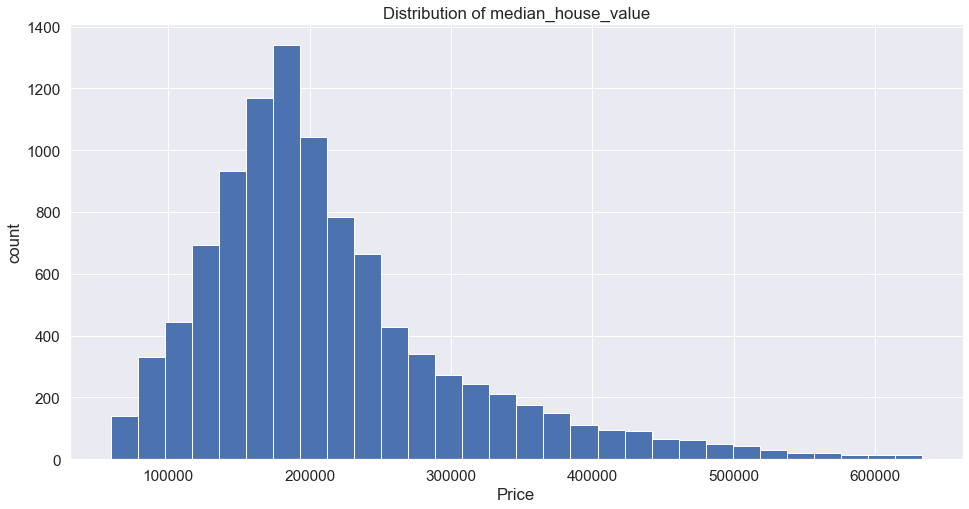

In [200]:
plt.figure(figsize=(16, 8))

df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of median_house_value')
plt.show()

### Анализ признаков

In [201]:
df_num_features = df.select_dtypes(include=['float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)

In [202]:
df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Healthcare_1
0,3.0,115.027313,NaN,10.0,10.0,0.075424,NaN
1,1.0,39.832523,23.169222,8.0,8.0,0.118537,1183.0
2,3.0,78.342216,47.671970,10.0,17.0,0.025609,240.0
3,1.0,40.409908,NaN,1.0,22.0,0.007122,NaN
4,2.0,64.285065,38.562515,9.0,16.0,0.282798,NaN


In [203]:
df['LifeSquare'].fillna(df['LifeSquare'].median(), inplace=True)

In [204]:
np.quantile(df['Rooms'], q=0.025)

1.0

In [205]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

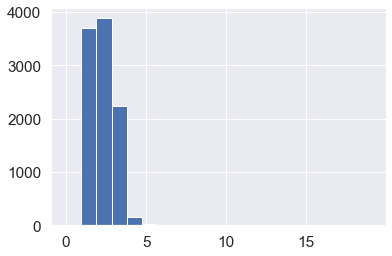

In [206]:
df['Rooms'].hist(bins=20)
plt.show()

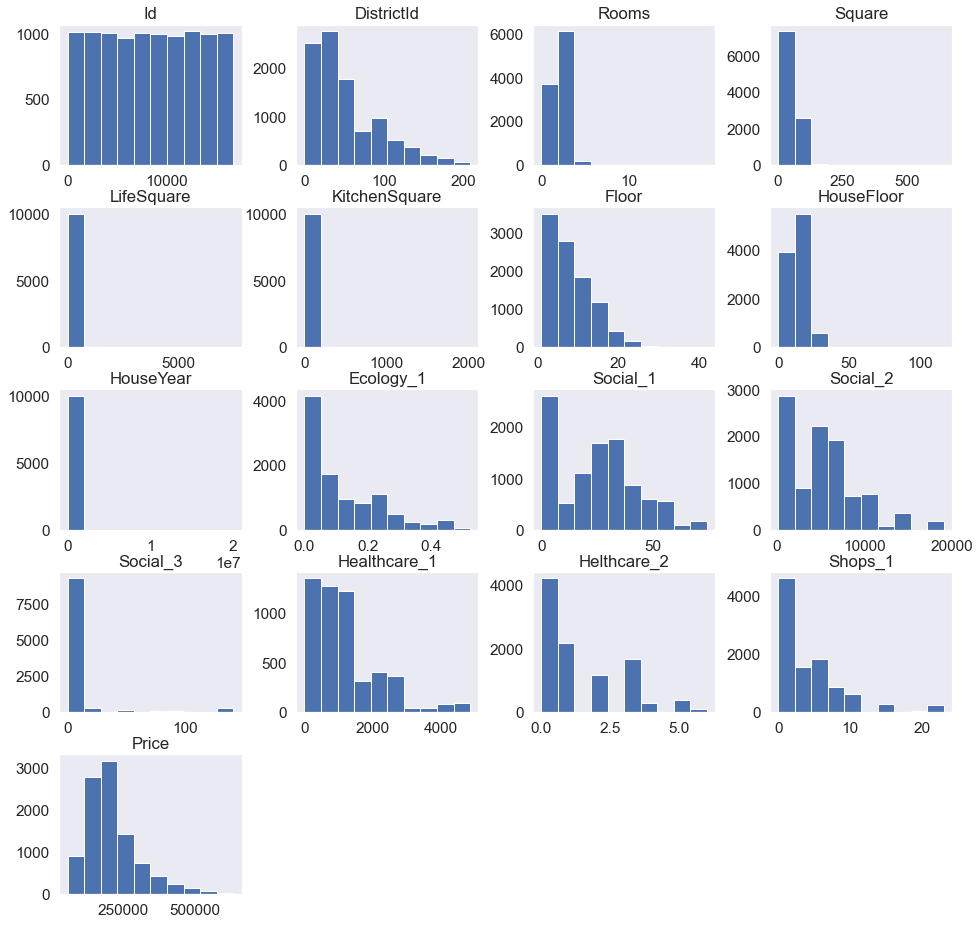

In [207]:
df.hist(figsize=(16, 16), bins=10, grid=False)
plt.show()

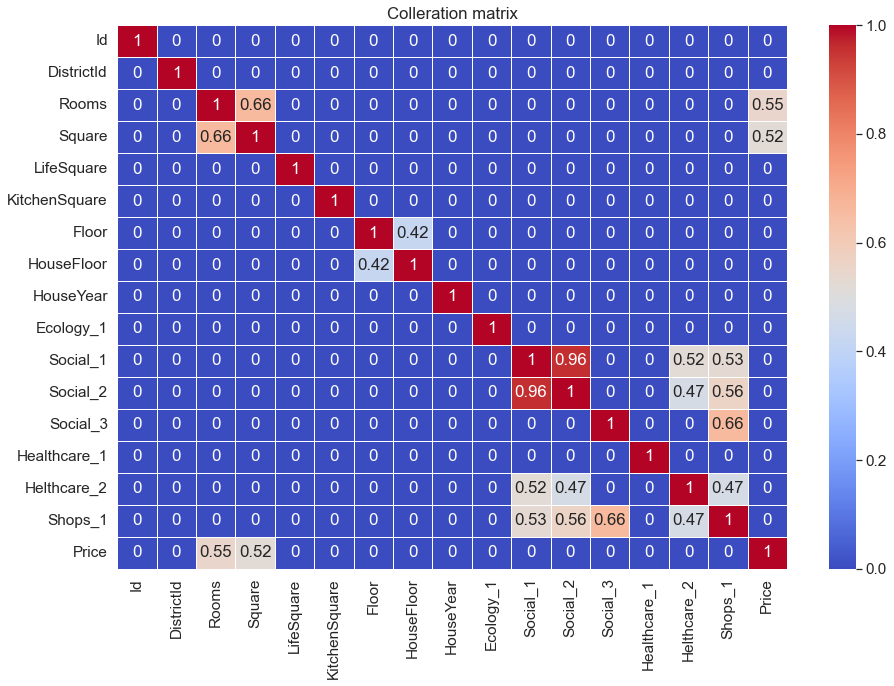

In [208]:
plt.figure(figsize=(15, 10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.4] = 0

sns.heatmap(corr_matrix, annot=True, linewidth=.5, cmap='coolwarm')

plt.title('Colleration matrix')
plt.show()

### Разделение данных

In [271]:
X = df.drop(columns='Price')

In [272]:
y = df['Price']

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=100)

### Предобработка данных и Feature engineering

In [274]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.Healthcare_1_median = None
        self.Rooms_median = None
        self.Square_median = None
        self.LifeSquare_median = None
        self.KitchenSquare_median = None
        self.HouseFloor_median = None
        self.HouseYear_median = None
        self.Social_1_median = None
        self.Social_2_median = None
        self.Social_3_median = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.Healthcare_1_median = df['Healthcare_1'].median()
        self.Rooms_median = df['Rooms'].median()
        self.Square_median = df['Square'].median()
        self.LifeSquare_median = df['LifeSquare'].median()
        self.KitchenSquare_median = df['KitchenSquare'].median()
        self.HouseFloor_median = df['HouseFloor'].median()
        self.HouseYear_median = df['HouseYear'].median()
        self.Social_1_median = df['Social_1'].median()
        self.Social_2_median = df['Social_2'].median()
        self.Social_3_median = df['Social_3'].median()
        
        
        
    def transform(self, df):
        """Трансформация данных"""
        
    # 1. Пропуски
        df['LifeSquare_nan'] = 0
        df.loc[df['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
        df['Healthcare_1_nan'] = 0
        df.loc[df['Healthcare_1'].isna(), 'Healthcare_1_nan'] = 1
        df['Healthcare_1'].fillna(self.Healthcare_1_median, inplace=True)
        df['LifeSquare'].fillna((0.61 * df['Square']), inplace=True)
        
    # 2. Исключение ненужных столбцов
        #df.drop(columns=['DistrictId'], inplace=True)
        df['Id'] = df['Id'].astype('str')
        
        
    # 3. Выбросы (outliers)

        
        # Rooms
        condition = (df['Rooms'] < 1) | (df['Rooms'] > 5)
        df['Rooms_outlier'] = 0
        df.loc[condition, 'Rooms_outlier'] = 1
        df.loc[condition, ['Rooms']] = 1
            
        # Square
        square_max_value = 130
        square_min_value = 10
        condition = (df['Square'] > square_max_value) | (df['Square'] <= square_min_value)
        df['Square_outlier'] = 0
        df.loc[condition, 'Square_outlier'] = 1
        df.loc[condition, 'Square'] = self.Square_median

        # KitchenSquare
        kitchen_max_value = 50
        kitchen_min_value = 5
        condition = (df['KitchenSquare'] > kitchen_max_value) | (df['KitchenSquare'] < kitchen_min_value)
        df['KitchenSquare_outlier'] = 0
        df.loc[condition, 'KitchenSquare_outlier'] = 1
        df.loc[condition, 'KitchenSquare'] = self.KitchenSquare_median

        # LifeSquare
        lifesquare_max_value = 130
        lifesquare_min_value = 5
        condition = (df['LifeSquare'] < lifesquare_min_value) |\
            (df['LifeSquare'] >= (df['Square'] - df['KitchenSquare'])) |\
            (df['LifeSquare'] > lifesquare_max_value) 
        df['LifeSquare_outlier'] = 0
        df.loc[condition, 'LifeSquare_outlier'] = 1
        df.loc[condition, 'LifeSquare'] = (self.LifeSquare_median / self.Square_median) * df['Square']

        # HouseFloor
        housefloor_max_value = 25
        condition = (df['HouseFloor'] < 1) | (df['HouseFloor'] > housefloor_max_value)
        df['HouseFloor_outlier'] = 0
        df.loc[condition, 'HouseFloor_outlier'] = 1
        df.loc[condition, 'HouseFloor'] = self.HouseFloor_median

        # Floor
        df['Floor_outlier'] = 0
        df.loc[(df['HouseFloor'] < df['Floor']), 'Floor_outlier'] = 1
        df.loc[(df['HouseFloor'] < df['Floor']), 'Floor']  = df['HouseFloor']

        # HouseYear
        house_year_min_value = np.quantile(df['HouseYear'], q=0.025)
        condition =  (df['HouseYear'] > 2021) | (df['HouseYear'] < house_year_min_value)
        df['HouseYear_outlier'] = 0
        df.loc[condition, 'HouseYear_outlier'] = 1
        df.loc[condition, 'HouseYear'] = self.HouseYear_median
        
        
#         # Social_1
#         #social_1_max_value = np.quantile(df['Social_1'], q=0.975)
#         social_1_min_value = 1
#         condition = (df['Social_1'] < social_1_min_value) #| (df['Social_1'] > social_1_max_value) 
#         df['Social_1_outlier'] = 0
#         df.loc[condition, 'Social_1_outlier'] = 1
#         df.loc[condition, 'Social_1'] = self.Social_1_median
        
#         # Social_2
#         social_2_max_value = np.quantile(df['Social_2'], q=0.975)
#         social_2_min_value = np.quantile(df['Social_2'], q=0.025)
#         condition = (df['Social_2'] > social_2_max_value) | (df['Social_2'] < social_2_min_value)
#         df['Social_2_outlier'] = 0
#         df.loc[condition, 'Social_2_outlier'] = 1
#         df.loc[condition, 'Social_2'] = self.Social_2_median

#         # Social_3
#         social_3_max_value = 20
#         social_3_min_value = 0
#         condition = (df['Social_3'] > social_3_max_value) | (df['Social_3'] < social_3_min_value)
#         df['Social_3_outlier'] = 0
#         df.loc[condition, 'Social_3_outlier'] = 1
#         df.loc[condition, 'Social_3'] = self.Social_3_median

        
    # 4. Изменение типа
            
        # Shops_2
        df.loc[df['Shops_2'] == 'A', 'Shops_2'] = 1
        df.loc[df['Shops_2'] == 'B', 'Shops_2'] = 0
        df['Shops_2'] = df['Shops_2'].astype(int)

        # Ecology_2
        df.loc[(df['Ecology_2'] == 'A'), 'Ecology_2'] = 1
        df.loc[(df['Ecology_2'] == 'B'), 'Ecology_2']  = 0
        df['Ecology_2'] = df['Ecology_2'].astype(int)

        # Ecology_3
        df.loc[(df['Ecology_3'] == 'A'), 'Ecology_3'] = 1
        df.loc[(df['Ecology_3'] == 'B'), 'Ecology_3']  = 0
        df['Ecology_3'] = df['Ecology_3'].astype(int)
            
    # 5. Новые фичи (features)
        
        # Слияние Social_1 и Social_2
        #df['Social_1_2'] = (df['Social_2'] - self.Social_2_mean)/ df['Social_2'].value_counts().sum() + (df['Social_1'] - self.Social_1_mean)/ df['Social_1'].value_counts().sum()
        #df.drop(['Social_1', 'Social_2'], axis=1, inplace=True)

        # Отношение LifeSquare/Square
        df['LifeSquare/Square'] = (df['LifeSquare'] / df['Square'])
        
        # Отношение Rooms/Square
        df['Square/Rooms'] = (df['Square'] / df['Rooms'])

        # Нежилая площадь
        df['NonresidentialSquare'] = df['Square'] - df['LifeSquare'] - df['KitchenSquare']
        
        def floor_to_cat(X):
    
            X['floor_cat'] = 0

            X.loc[(X['Floor'] == 1), 'floor_cat'] = 1
            X.loc[(X['Floor'] >= 2) & (X['Floor'] < 5), 'floor_cat'] = 2
            X.loc[(X['Floor'] >= 5) & (X['Floor'] < 10), 'floor_cat'] = 3
            X.loc[(X['Floor'] >= 10) & (X['Floor'] < 15), 'floor_cat'] = 4
            X.loc[(X['Floor'] >= 15) & (X['Floor'] < 25), 'floor_cat'] = 5
            X.loc[(X['Floor'] >= 25), 'floor_cat'] = 6
            
            return X
        
        # Категоризация этажности
        
        df = floor_to_cat(df)
        
        # Категоризация возраста дома
        
        df['house_age'] = 2021 - df['HouseYear']
        def age_to_cat(X):
    
            X['age_cat'] = 0

            X.loc[df['house_age'] <= 5, 'age_cat'] = 1
            X.loc[(df['house_age'] > 5) & (df['house_age'] <= 10), 'age_cat'] = 2
            X.loc[(df['house_age'] > 10) & (df['house_age'] <= 15), 'age_cat'] = 3
            X.loc[(df['house_age'] > 15) & (df['house_age'] <= 25), 'age_cat'] = 4
            X.loc[(df['house_age'] > 25) & (df['house_age'] <= 40), 'age_cat'] = 5
            X.loc[(df['house_age'] > 40) & (df['house_age'] <= 45), 'age_cat'] = 6
            X.loc[(df['house_age'] > 45) & (df['house_age'] <= 55), 'age_cat'] = 7
            X.loc[(df['house_age'] > 55), 'age_cat'] = 8

            return X
        
        df = age_to_cat(df)

        
        return df

In [275]:
pipe = DataPipeline()
pipe.fit(X_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

X_train.isna().sum().sum(), X_test.isna().sum().sum()

(0, 0)

In [276]:
pd.set_option('display.max_columns', None)

In [277]:
X_train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare/Square,Square/Rooms,NonresidentialSquare,floor_cat,house_age,age_cat
8511,5355,74,1.0,53.865501,33.780174,6.0,9.0,12.0,1977,0.075779,0,0,6,1437,3,900.0,0,2,0,0,1,0,0,1,1,1,0,0,0.627121,53.865501,14.085327,3,44,6
1449,11764,93,3.0,52.272644,32.781261,6.0,3.0,3.0,1977,0.004949,0,0,0,186,0,900.0,0,0,0,0,1,0,1,1,0,0,1,0,0.627121,17.424215,13.491383,2,44,6
2965,15528,66,3.0,79.489578,47.728355,12.0,17.0,17.0,2001,0.111627,0,0,50,12238,8,1970.0,2,3,0,0,0,0,0,0,0,0,0,0,0.600435,26.496527,19.761223,5,20,4
9497,10578,22,2.0,45.578159,28.475996,5.0,3.0,5.0,1962,0.118537,0,0,30,6207,1,1183.0,1,0,0,0,0,0,0,0,0,0,0,0,0.624773,22.789080,12.102163,2,59,8
5488,1490,31,1.0,35.803776,20.454700,6.0,1.0,9.0,1974,0.151346,0,1,32,5889,10,830.0,4,1,0,0,0,0,0,0,0,0,0,0,0.571300,35.803776,9.349075,1,47,7


In [278]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6700 entries, 8511 to 5640
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     6700 non-null   object 
 1   DistrictId             6700 non-null   int16  
 2   Rooms                  6700 non-null   float32
 3   Square                 6700 non-null   float32
 4   LifeSquare             6700 non-null   float32
 5   KitchenSquare          6700 non-null   float32
 6   Floor                  6700 non-null   float32
 7   HouseFloor             6700 non-null   float32
 8   HouseYear              6700 non-null   int32  
 9   Ecology_1              6700 non-null   float32
 10  Ecology_2              6700 non-null   int32  
 11  Ecology_3              6700 non-null   int32  
 12  Social_1               6700 non-null   int8   
 13  Social_2               6700 non-null   int16  
 14  Social_3               6700 non-null   int16  
 15  H

In [279]:
feature_names_for_stand = X_train.select_dtypes(include=['float64','float32', 'float16', 'int64', 'int32', 'int16', 'int8']).columns

target_name = 'Price'

### Нормализация

In [173]:
scaler = StandardScaler()

colnames = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2',
       'Shops_1', 'Shops_2']
colnames

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2']

In [174]:

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[colnames]), columns=colnames)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[colnames]), columns=colnames)

X_train_scaled.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,0.537930,-1.088847,-0.098990,0.079511,-0.563596,0.215858,-0.136820,-0.491964,-0.363941,-0.102752,-0.169911,-1.054411,-0.968355,-0.215159,-0.170292,-0.880609,-0.461507,-0.304057
1,0.973156,1.380361,-0.188844,-0.011918,-0.563596,-0.957253,-1.630346,-0.491964,-0.958822,-0.102752,-0.169911,-1.396071,-1.280438,-0.341130,-0.170292,-0.880609,-0.876665,-0.304057
2,0.354677,1.380361,1.346483,1.356163,1.856202,1.780007,0.692917,0.877559,-0.062856,-0.102752,-0.169911,1.451093,1.726134,-0.005208,1.262457,0.448837,-0.253928,-0.304057
3,-0.653215,0.145757,-0.566485,-0.405972,-0.966896,-0.957253,-1.298451,-1.347916,-0.004821,-0.102752,-0.169911,0.312228,0.221601,-0.299139,0.208650,-0.215886,-0.876665,-0.304057
4,-0.447055,-1.088847,-1.117865,-1.140147,-0.563596,-1.348290,-0.634662,-0.663154,0.270734,-0.102752,5.885431,0.426114,0.142270,0.078772,-0.264023,1.778283,-0.669086,-0.304057


### Анализ групп признаков

In [175]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [176]:
def reduce_dims(df, dims=2, method='tsne', perplexity=30):
    assert method in 'tsne', 'Неверно указан метод'
    
    if method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames)

In [177]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)
    
    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2',
                                      c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                      alpha=0.5, figsize=figsize)
    else:
          components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)
    
    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')
    plt.show()

In [178]:
def apply_elbow_method(X):
    
    distortions = []
    K = range(2, 30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [183]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [184]:
dim_reducer2d_tsne, components_2d_tsne = reduce_dims(X_train_scaled, dims=2, method='tsne', perplexity=50)

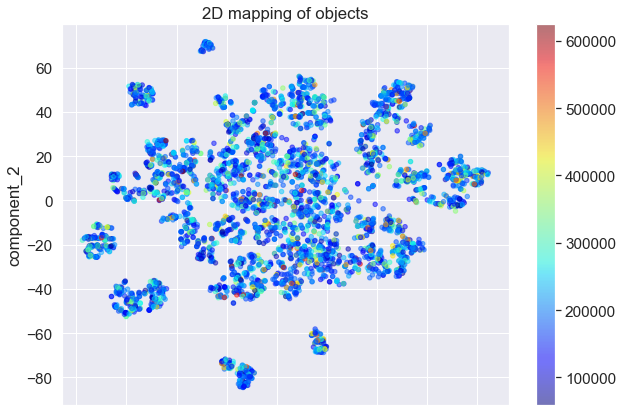

In [185]:
display_components_in_2D_space(components_2d_tsne, y_train)

### Выделение кластеров

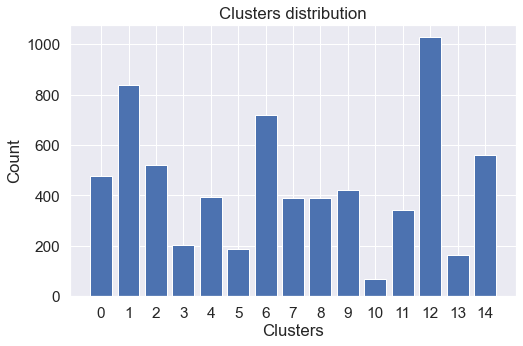

In [189]:
kmeans = KMeans(n_clusters=15, random_state=42)
labels_clast = kmeans.fit_predict(X_train_scaled)
labels_clast = pd.Series(labels_clast, name='clusters')

labels_clast_test = kmeans.predict(X_test_scaled)
labels_clast_test = pd.Series(labels_clast, name='clusters')

unique, counts = np.unique(labels_clast, return_counts=True)
display_clusters_distribution(unique, counts)

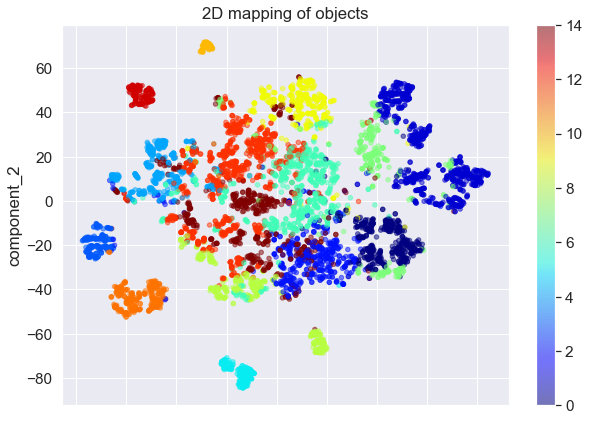

In [191]:
display_components_in_2D_space(components_2d_tsne, labels_clast)

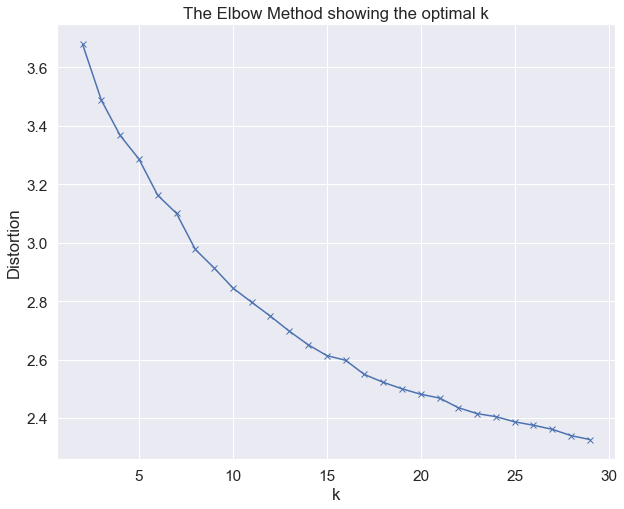

In [192]:
apply_elbow_method(X_train_scaled)

### Построение модели

In [218]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [254]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=150)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)

Train R2:	0.935
Test R2:	0.725


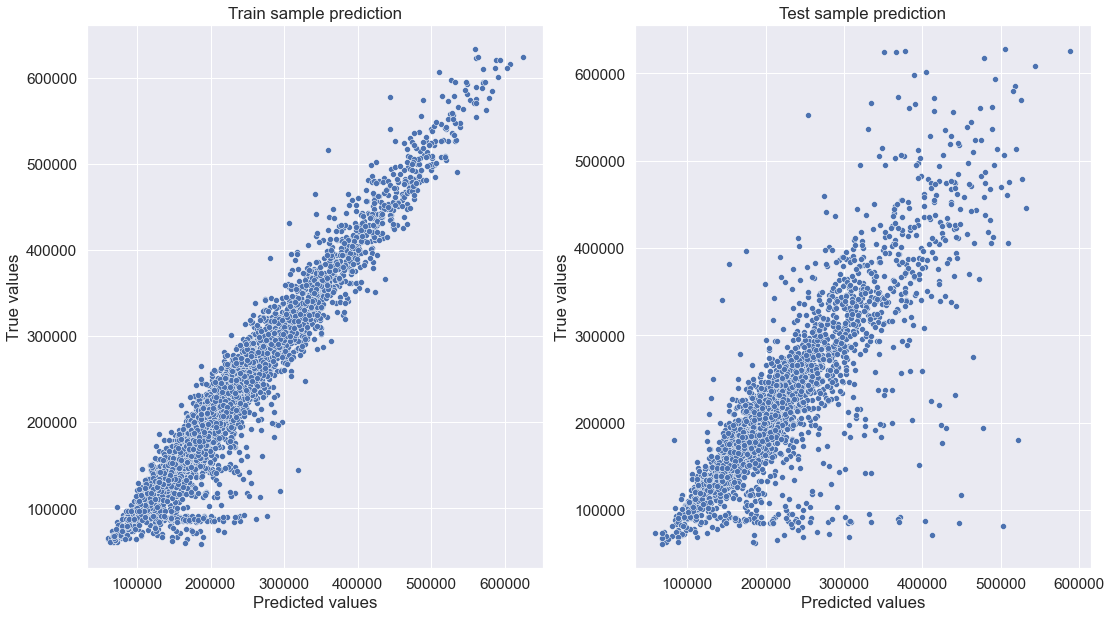

In [255]:
y_test_preds = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Настройка и оценка финальной модели

#### Кросс-валидация

In [228]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.71870925, 0.74896201, 0.74215068])

In [229]:
cv_score.mean()

0.7366073128371999

In [89]:
%%time
params = {'n_estimators':[200],
         'max_depth':[5, 8, 10, 20],
         'min_samples_leaf':[6, 2]}

gs = GridSearchCV(gb_model, params,
                  scoring='r2',
                  cv=KFold(n_splits=5,
                          random_state=21,
                          shuffle=True),
                  n_jobs=-1
                 )
gs.fit(X_train, y_train)
                  

Wall time: 1min 42s


GridSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
             estimator=GradientBoostingRegressor(criterion='mse', max_depth=7,
                                                 min_samples_leaf=10,
                                                 n_estimators=150,
                                                 random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 8, 10, 20],
                         'min_samples_leaf': [6, 2], 'n_estimators': [200]},
             scoring='r2')

In [70]:
gs.best_params_

{'max_depth': 5, 'min_samples_leaf': 6, 'n_estimators': 200}

In [71]:
gs.best_score_

0.7441610449555439

#### Обучение и оценка модели

In [280]:
final_model = GradientBoostingRegressor(criterion='mse',
                                       max_depth=5,
                                       min_samples_leaf=6,
                                       random_state=42,
                                       n_estimators=200)
final_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=6,
                          n_estimators=200, random_state=42)

Train R2:	0.902
Test R2:	0.735


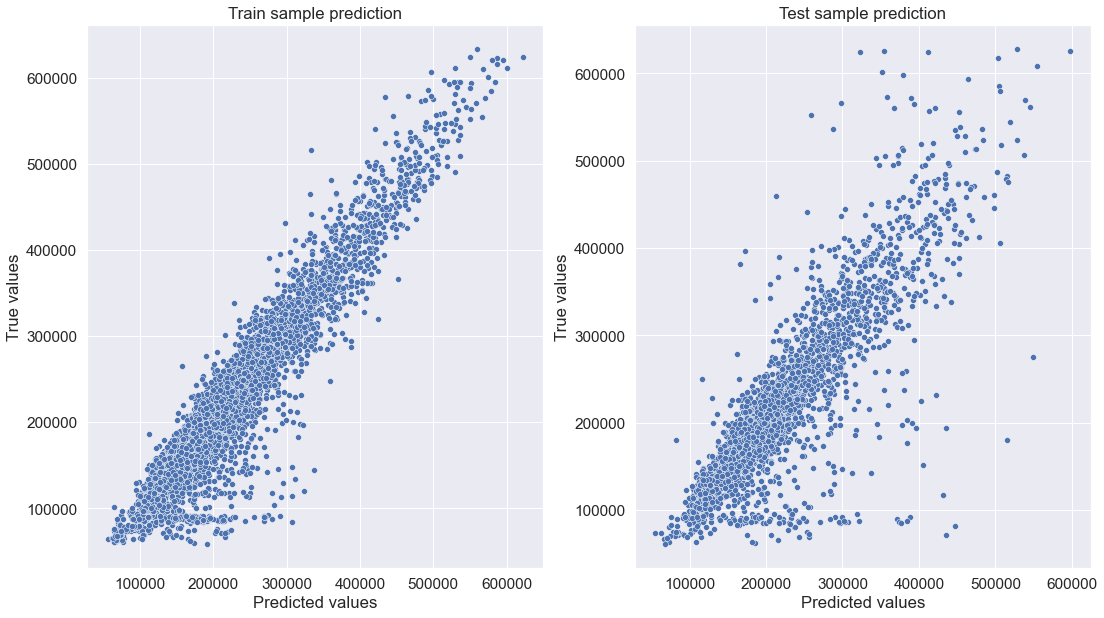

In [281]:
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

### Анализ прогнозов

In [258]:
final_model.feature_importances_

array([7.22466567e-03, 6.23853864e-02, 6.65095159e-02, 3.76330659e-01,
       3.29770961e-02, 1.68234233e-02, 7.44528961e-03, 1.41125021e-02,
       9.98559781e-03, 4.76148938e-02, 8.72503110e-05, 6.87922473e-04,
       2.96175702e-02, 1.48876193e-01, 6.99729232e-02, 2.14323212e-02,
       3.39630476e-03, 1.41304667e-02, 5.99532598e-04, 0.00000000e+00,
       4.33636323e-04, 0.00000000e+00, 4.74799040e-03, 4.93526201e-03,
       1.08340886e-03, 9.16709496e-04, 2.96296842e-04, 3.04179268e-03,
       4.15187581e-04, 8.22851762e-03, 2.02704863e-02, 1.22600528e-02,
       1.52706408e-03, 1.10805531e-02, 5.53527941e-04])

In [259]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

In [260]:
feature_importances

,feature_name,importance
3,Square,0.376331
13,Social_2,0.148876
14,Social_3,0.069973
2,Rooms,0.066510
1,DistrictId,0.062385
9,Ecology_1,0.047615
4,LifeSquare,0.032977
12,Social_1,0.029618
15,Healthcare_1,0.021432
30,Square/Rooms,0.020270


### Сохранение модели

In [261]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

In [262]:
with open(MODEL_FILE_PATH, 'rb') as file:
    my_model = pickle.load(file)
    
my_model

GradientBoostingRegressor(criterion='mse', max_depth=5, min_samples_leaf=6,
                          n_estimators=200, random_state=42)

Kaggle

In [282]:
DATASET_TEST = './test.csv'

df_test = pd.read_csv(DATASET_TEST, sep=',')

In [283]:
df_test = pipe.transform(df_test)

In [284]:
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,LifeSquare_nan,Healthcare_1_nan,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,HouseFloor_outlier,Floor_outlier,HouseYear_outlier,LifeSquare/Square,Square/Rooms,NonresidentialSquare,floor_cat,house_age,age_cat
0,4567,44,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,0,0,24,4378,0,1036.0,1,1,0,0,0,0,0,0,0,0,0,0,0.518193,36.847630,12.753448,3,51,7
1,5925,62,1.0,42.493907,26.648813,10.0,7.0,17.0,2017,0.072158,0,0,2,629,1,900.0,0,0,1,0,1,0,0,0,1,0,0,0,0.627121,42.493907,5.845094,3,4,1
2,960,27,2.0,59.463678,36.272844,9.0,19.0,19.0,1977,0.211401,0,0,9,1892,0,900.0,0,1,0,1,1,0,0,0,0,0,0,0,0.610000,29.731839,14.190835,5,44,6
3,3848,23,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,0,0,2,475,0,900.0,0,0,0,0,1,0,0,0,0,0,0,0,0.682710,16.548677,9.752204,2,56,8
4,746,74,1.0,53.837056,32.840604,6.0,8.0,17.0,1977,0.309479,0,0,35,7715,4,990.0,0,6,0,1,0,0,0,1,0,0,0,0,0.610000,53.837056,14.996452,3,44,6


In [285]:
test_preds = final_model.predict(df_test)

In [286]:
submission = pd.DataFrame(df_test['Id'])
submission['Price'] = pd.DataFrame(test_preds)
submission

,Id,Price
0,4567,166289.038747
1,5925,119129.627591
2,960,153913.729574
3,3848,124119.951346
4,746,219297.574361
...,...,...
4995,10379,174877.098930
4996,16138,388050.599799
4997,3912,147857.192291
4998,5722,199823.766641


In [287]:
submission.set_index('Id', inplace=True)

In [288]:
submission.describe()

,Price
count,5000.000000
mean,215961.512174
std,79888.555978
min,63983.627773
25%,164443.746324
50%,196356.242018
75%,250472.326241
max,599966.199725


In [289]:
submission.to_csv('./submission.csv', sep=',')